<a href="https://colab.research.google.com/github/sattviksahai/CS583B_Recitation/blob/master/sinewave_exercise_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sys
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, Activation, Bidirectional, Flatten
from tensorflow.keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

In [0]:
# Parameters
batch_size = 256
sequence_len = 500
train_dataset_len = 90000
validation_dataset_len = 10000
testing_dataset_len = 50000
epochs = 20

Define dataset generator function

In [0]:
# Function definitions
class Dataset():
  def __init__(self, seq_len, frequency_ranges, amplitude_range, dataset_length):
    self.seq_len = seq_len
    self.frequency_ranges = []
    for freq_range in frequency_ranges:
      self.frequency_ranges.append(freq_range)
    self.amplitude_range = amplitude_range
    self.dataset_length = dataset_length

  def __len__(self):
      return self.dataset_length

  def sine_generator(self, length, freq, ampl):
      sine_wave = np.sin(2*np.pi*np.arange(length)*freq/length)
      return sine_wave

  def __getitem__(self, idx, freq_idx):
      frequency_scalar = random.uniform(self.frequency_ranges[freq_idx][0],self.frequency_ranges[freq_idx][1])
      amplitude_scalar = random.uniform(self.amplitude_range[0],self.amplitude_range[1])
      data = self.sine_generator(self.seq_len, frequency_scalar, amplitude_scalar)
      return np.asarray(data), frequency_scalar

  def generate(self):
    x=[]
    y=[]
    for freq_idx in range(len(self.frequency_ranges)):
      for i in range(int(self.dataset_length/len(self.frequency_ranges))):
        datapoint = self.__getitem__(i, freq_idx)
        x.append(datapoint[0])
        y.append(datapoint[1])
    return np.array(x),np.array(y)

Define your model

In [14]:
# Define Model
model = Sequential()
model.add(LSTM(32, activation='tanh', input_shape=(sequence_len,1)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='relu'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 5,441
Trainable params: 5,441
Non-trainable params: 0
_________________________________________________________________


Generate Training Dataset

In [0]:
(x_train, y_train) = Dataset(sequence_len,[(10,20), (30, 40), (50,60)],(1,5), train_dataset_len).generate()
print(x_train.shape, y_train.shape)

(90000, 500) (90000,)


Generate Validation Dataset

In [0]:
(x_val, y_val) = Dataset(sequence_len,[(20,30)],(1,5), validation_dataset_len).generate()
print(x_val.shape, y_val.shape)

(10000, 500) (10000,)


Generate Testing Dataset

In [0]:
(x_test, y_test) = Dataset(sequence_len,[(40,50)],(1,5), testing_dataset_len).generate()
print(x_test.shape, y_test.shape)

(50000, 500) (50000,)


Sanity check

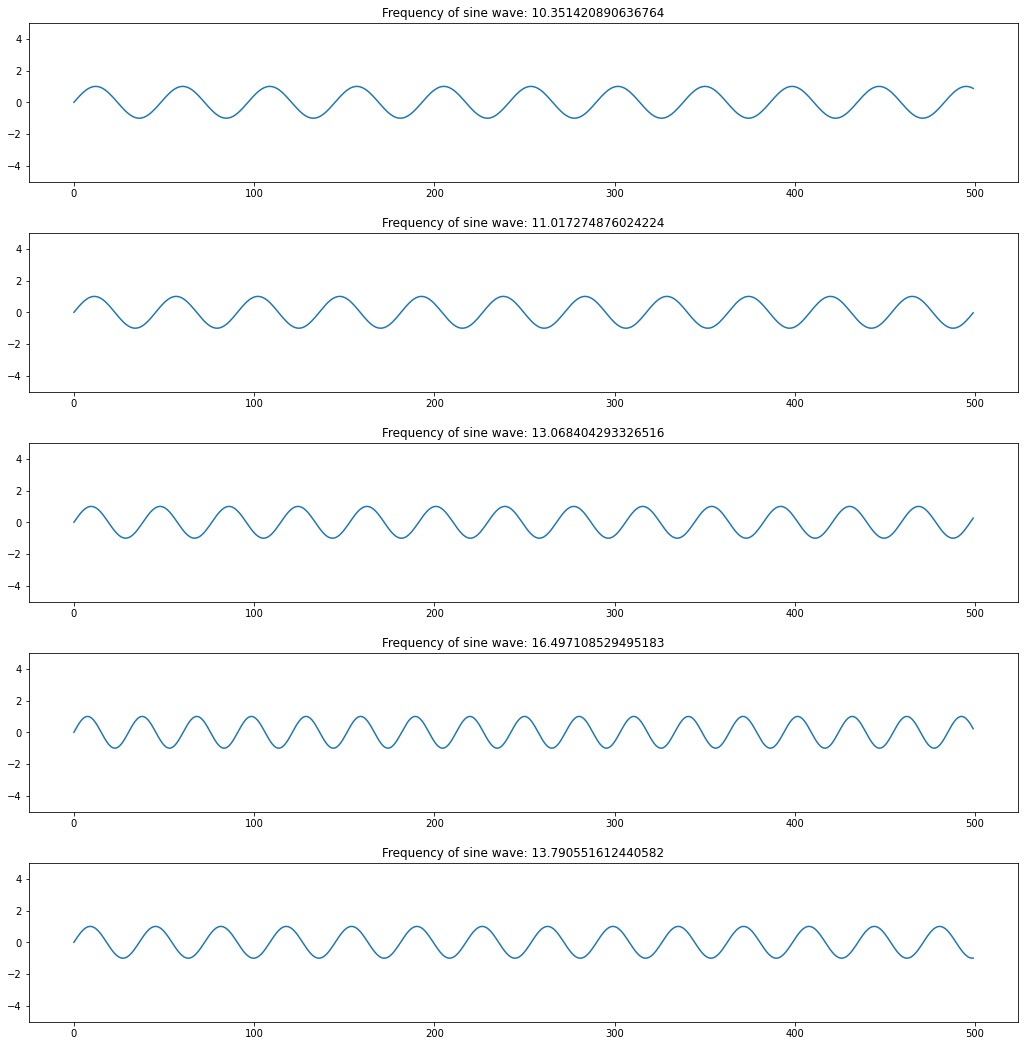

In [0]:
fig, axs = plt.subplots(5)
fig.set_figheight(15)
fig.set_figwidth(15)
fig.tight_layout(pad=3.0)
for i, (data, gt_freq) in enumerate(zip(x_train, y_train)):
    axs[i].plot(np.arange(len(data)), data)
    axs[i].title.set_text("Frequency of sine wave: {}".format(gt_freq))
    axs[i].set_ylim(-5,5)
    if i>=4:
        break
plt.show()

Compile model

In [0]:
model.compile(optimizer=optimizers.RMSprop(lr=0.01),
            loss='mean_squared_error')

Train

In [0]:
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
# history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), callbacks=callbacks_list)
history = model.fit(np.expand_dims(x_train, axis=-1), np.expand_dims(y_train, axis=-1), epochs=epochs, batch_size=batch_size, validation_data=(np.expand_dims(x_val, axis=-1), np.expand_dims(y_val, axis=-1)), callbacks=callbacks_list)

Epoch 1/20
352/352 [==============================] - ETA: 0s - loss: 220.9069
Epoch 00001: val_loss improved from inf to 245.65323, saving model to weights.best.hdf5
352/352 [==============================] - 132s 374ms/step - loss: 220.9069 - val_loss: 245.6532
Epoch 2/20
352/352 [==============================] - ETA: 0s - loss: 204.9563
Epoch 00002: val_loss improved from 245.65323 to 128.90633, saving model to weights.best.hdf5
352/352 [==============================] - 137s 389ms/step - loss: 204.9563 - val_loss: 128.9063
Epoch 3/20
352/352 [==============================] - ETA: 0s - loss: 152.8628
Epoch 00003: val_loss improved from 128.90633 to 107.26947, saving model to weights.best.hdf5
352/352 [==============================] - 133s 378ms/step - loss: 152.8628 - val_loss: 107.2695
Epoch 4/20
352/352 [==============================] - ETA: 0s - loss: 257.3628
Epoch 00004: val_loss did not improve from 107.26947
352/352 [==============================] - 133s 378ms/step - los

Define Testing Model

In [0]:
# Define Model
eval_model = Sequential()

eval_model.add(LSTM(32, activation='tanh', input_shape=(sequence_len,1)))
eval_model.add(Dense(32, activation='relu'))
eval_model.add(Dense(1, activation='relu'))

eval_model.summary()

eval_model.load_weights("weights.best.hdf5")
eval_model.compile(optimizer=optimizers.RMSprop(lr=0.01),
            loss='mean_squared_error')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 5,441
Trainable params: 5,441
Non-trainable params: 0
_________________________________________________________________


Evaluate Model

In [0]:
# eval_model.evaluate(x_test, y_test)
eval_model.evaluate(np.expand_dims(x_test, axis=-1), np.expand_dims(y_test, axis=-1))

1563/1563 [==============================] - 59s 38ms/step - loss: 0.9883


0.9883013963699341

Visualize a few predictions

(20, 1) (50000,)


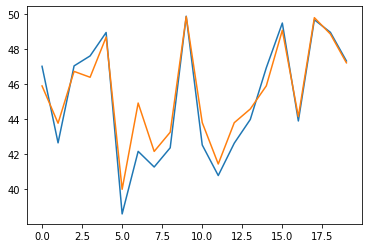

In [0]:
prediction = eval_model.predict(np.expand_dims(x_test[:20], axis=-1))
print(prediction.shape, y_test.shape)
plt.plot(prediction)
plt.plot(y_test[:20])
plt.show()